In [1]:
# Set to a path on your local machine where you want to save data/figures
path = "/home/kenny/Nextcloud3/kenny-storage/Research/QIS/Intro-to-Analog-Quantum-Computing/"

# import basics and ahs specific components
import numpy as np
import matplotlib.pyplot as plt
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from ahs_utils import show_register, show_global_drive, show_final_avg_density, get_drive
from braket.devices import LocalSimulator
from braket.aws import AwsDevice 

# Sets the device to Aquila - QuEra's first public QPU
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# Gives us the capabilities of Aquila
capabilities = qpu.properties.paradigm
rydberg = capabilities.rydberg
rydberg

Rydberg(c6Coefficient=Decimal('5.42E-24'), rydbergGlobal=RydbergGlobal(rabiFrequencyRange=(Decimal('0.0'), Decimal('15800000.0')), rabiFrequencyResolution=Decimal('400.0'), rabiFrequencySlewRateMax=Decimal('250000000000000.0'), detuningRange=(Decimal('-125000000.0'), Decimal('125000000.0')), detuningResolution=Decimal('0.2'), detuningSlewRateMax=Decimal('2500000000000000.0'), phaseRange=(Decimal('-99.0'), Decimal('99.0')), phaseResolution=Decimal('5E-7'), timeResolution=Decimal('1E-9'), timeDeltaMin=Decimal('5E-8'), timeMin=Decimal('0.0'), timeMax=Decimal('0.000004')))

# Two-Leg Ladder

In this notebook, we show how to simulate a single-site two-leg ladder.

First, define the evolution parameters. It is useful to know our $\Omega$ in advance of setting the rung spacing, since $\Omega$ determines the blockade radius. We will evolve for roughly the full possible time subject to a nearly constant $\Omega=4\pi$ MHz.

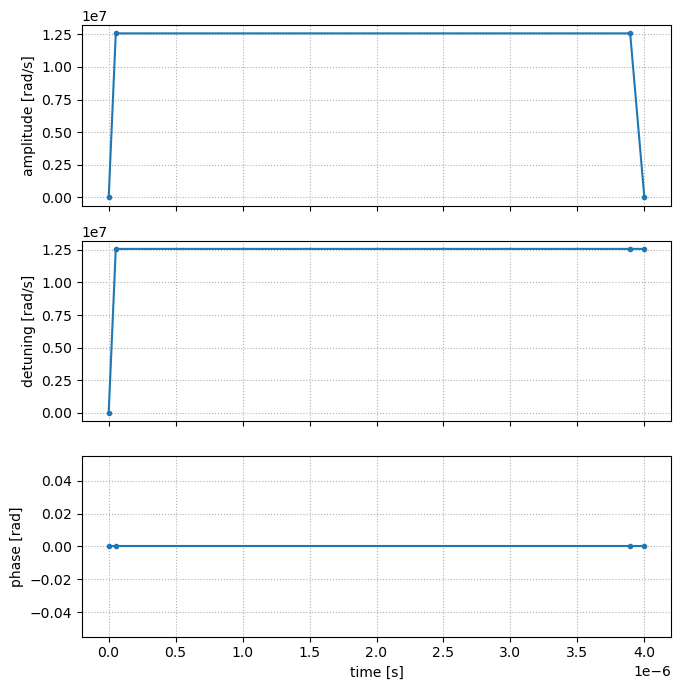

In [2]:
# Hamiltonian drive construction


total_time = 4.0e-6 # total evolution time in s

# The machine must start and end with Omega at 0. Therefore, we must leave time at the beginning and end
#  of the simulation for ramping Omega to our desired value and then ramping back down to 0. There is a finite
#  speed at which Omega can be changed, called the slew rate. We define that below and then use it to determine
#  the smallest possible ramp up/down time given our desired constant Omega
max_slew = float(rydberg.rydbergGlobal.rabiFrequencySlewRateMax) # rad/s^2 advised to only use 95% of max for now
omega_min= 0  # rad/s
omega_max = np.pi*4.0e6 # rad/s
ramp_time = omega_max/(max_slew*0.95) # microseconds

# The Hamiltonian drive is constructed in terms of time points where the parameters of the analog device are changed.
# To implement evolution under constant Omega, we start at time t_0=0 then ramp up to desired Omega.
#  The desired Omega is reached at t_1=ramp_time defined above. We then evolve for the rest of the possible time
#  minus the time needed to ramp down. This means we will have a t_2=total_time-2*ramp_time and end with our final time
#  t_3=total_time. We make an array out of these time points below.
time_points = [0, ramp_time, total_time-2*ramp_time, total_time]

# For this simulation, we want the detuning to exactly track omega. It is entirely possible to do something different, but
#  we need to make sure the points in time at which parameters are changing is defined in the above array.
detuning_min = omega_min
detuning_max = omega_max 

# We now construct arrays of Omega and Detuning values that match the time_points above.
omega_values = [omega_min, omega_max, omega_max, omega_min]  # piecewise linear
detuning_values = [detuning_min, detuning_max, detuning_max, detuning_max]  # piecewise linear

# For this simulation, set phase to 0 at all time.
phase_values = [0, 0, 0, 0]  # piecewise constant

# Define the drive via the following function that takes in all previously defined arrays.
const_drive = get_drive(time_points, omega_values, detuning_values, phase_values)

# We can view the drive pattern by running the below function.
show_global_drive(const_drive)

Second, define the atomic register our global drive will act upon.

In [3]:
# Define the Rydberg blockade radius corresponding to our previously defined Omega
c6 = float(rydberg.dict()["c6Coefficient"])
Rb = (c6/omega_max)**(1/6)
Rb

8.69223722541915e-06

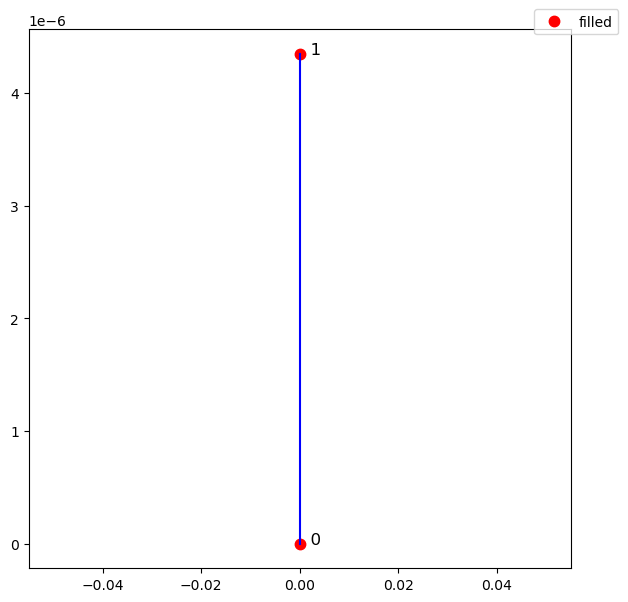

In [6]:
# Now we create the register of atoms
atoms = AtomArrangement()

# Single rung of two-leg ladder
num_rungs = 1
aspect_ratio = 0.5
inter_rung_spacing = Rb/2.0 # spacing between the two atoms on a single rung (same as scale in Bloqade)
outer_rung_spacing = inter_rung_spacing*aspect_ratio

# Construct the atom configuration
for i in range(num_rungs):
    for j in range(2):
        atoms.add([i*outer_rung_spacing, j*inter_rung_spacing])

# View the arrangement of atoms. Use blockade_radius=Rb to draw connecting line between blockaded atoms
show_register(atoms, blockade_radius=Rb)

Third, simulate our system using the local simulator."

In [7]:
program = AnalogHamiltonianSimulation(
    register=atoms,
    hamiltonian=const_drive
)

# When running on the actual QPU, you need to 'digitize' this program so that it properly
#  adheres to the physical constraints of the device. We do it here as well.
d_program = program.discretize(qpu)

# Set the local simulator as the run device for now. Set shots to number of measurements you want.
device = LocalSimulator("braket_ahs")
result = device.run(d_program, progress_bar=True, shots = 1000).result()

In [12]:
# We can quickly view the results of the run using some utility functions.
from ahs_utils import get_counts, get_avg_density

# This shows all the results of measurements as a dictionary
print(get_counts(result))

# This shows the average Rydberg (excitation) density for each atom
print(get_avg_density(result))

{'gg': 434, 'gr': 276, 'rg': 290}
[0.29  0.276]


Our previous simulation just looked at measurements taken at a single time. Let's suppose we're interested in simulating real-time evolution. In that case, we need to run a program like we just did for discrete time steps. Let's do that.

In [23]:
# number of time steps
num_steps = 100

# array that will hold our results
density_array = np.zeros((num_steps,2))


# times we will evolve over to create the time-evolution
# Note that you can't start at zero because this would mean the device does nothing and then measures.
clocks = np.linspace(0.2e-6,4.0e-6,num=num_steps)

# construct our evolution simulation loop
step = 0
for total_time in clocks:
    max_slew = float(rydberg.rydbergGlobal.rabiFrequencySlewRateMax) # rad/s^2 advised to only use 95% of max for now
    omega_min= 0  # rad/s
    omega_max = np.pi*4e6 # rad/s
    ramp_time = omega_max/(max_slew*0.95) # microseconds
    time_points = [0, ramp_time, total_time-2*ramp_time, total_time]
    detuning_min = omega_min
    detuning_max = omega_max 
    omega_values = [omega_min, omega_max, omega_max, omega_min]  # piecewise linear
    detuning_values = [detuning_min, detuning_max, detuning_max, 0]  # piecewise linear
    phase_values = [0, 0, 0, 0]  # piecewise constant
    const_drive = get_drive(time_points, omega_values, detuning_values, phase_values)

    program = AnalogHamiltonianSimulation(
        register=atoms, 
        hamiltonian=const_drive
    )
    d_program = program.discretize(qpu)
    device = LocalSimulator("braket_ahs")
    result = device.run(d_program, progress_bar=True, shots=200).result()

    # add data to array
    density_array[step,0] = get_avg_density(result)[0]
    density_array[step,1] = get_avg_density(result)[1]

    # increment counter
    step += 1


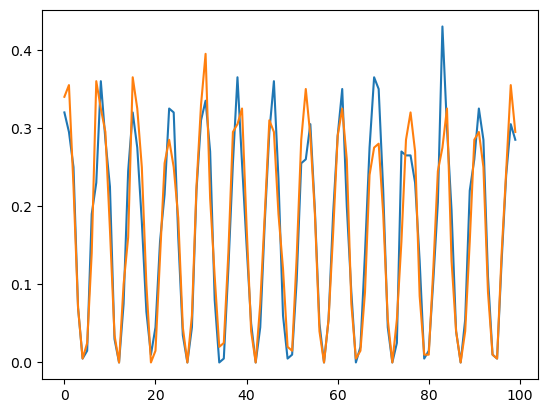

In [25]:
plot1 = plt.plot(density_array[:,0])
plot2 = plt.plot(density_array[:,1])

As we may have guessed, the two atoms are blockaded and therefore never reach close to full excitation. They both follow the same evolution. To see an atom arrangement where the atoms evolve differently try redoing the above simulations for three atoms rather than two. Can you extend this to a longer chain and find a way to reliably prepare a $Z_2$ or higher ordered state?